In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

In [2]:
# client = LocalCluster()
# client

In [3]:
fdir = "D:/crs/proj/2019_DorianOBX/WayneWright_flights/"

fnames = (\
          "post_Matthew_lidar_1m.tif",\
          "2019-08-30_1m_DEM_v1_crop.tif",\
          "2019-09-12-13_DEM_1m_v1_crop.tif")

titles = ([\
         "post-Matthew",\
         "pre-Dorian",\
         "post-Dorian"])

nf = len(fnames)

# optional median-filter smoothing of original maps
smooth = False
# kernal size...this should be an odd number >= dxy/0.1
ksize = 3

In [4]:
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

In [42]:
def map_stats(mp):
    '''
    Calculate some basic statistics for 3D map arrays
    '''
    mean = np.nanmean(mp,axis=(1,2))
    mad = np.nanmean(np.abs(mp),axis=(1,2))
    dmin = np.nanmin(mp,axis=(1,2))
    dmax = np.nanmax(mp,axis=(1,2))
    rms = np.sqrt(np.nanmean(mp**2.,axis=(1,2)))
    s = np.shape(mp)
    num = []
    numn = []
    for i in range(s[0]):
       num.append(mp[i,:,:].size)
       numn.append(np.count_nonzero(np.isnan(mp[i,:,:])))
    print("Shape: ",s)
    print("mean",mean)
    print("mad",mad)
    print("min",dmin)
    print("max",dmax)
    print("rms",rms)
    print("nans",numn)
    print("size",num)
    return mean, mad

In [6]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
xmax = 1800. # alongshore
ymax = 500.  # cross-shore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

xcoords = np.linspace(0.5*dxy,xmax-0.5*dxy,nx)
ycoords = np.linspace(0.5*dxy,ymax-0.5*dxy,ny)
# Y is ascending
xrot, yrot=np.meshgrid(xcoords, ycoords ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(500, 1800)
[[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 ...
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]]
yrot:
(500, 1800)
[[  0.5   0.5   0.5 ...   0.5   0.5   0.5]
 [  1.5   1.5   1.5 ...   1.5   1.5   1.5]
 [  2.5   2.5   2.5 ...   2.5   2.5   2.5]
 ...
 [497.5 497.5 497.5 ... 497.5 497.5 497.5]
 [498.5 498.5 498.5 ... 498.5 498.5 498.5]
 [499.5 499.5 499.5 ... 499.5 499.5 499.5]]


In [7]:
# Define the ROI with bottom left corner and rotation of axes
#e0 = 391210.; n0 = 3868600.
e0 = 391460.; n0 = 3868410.

rot = 43.

print('Shape of xrot, yrot: ',np.shape(xrot),np.shape(xrot))
shp = np.shape(xrot)
xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)
xu=np.reshape(xu,shp)
yu=np.reshape(yu,shp)
print('Shape of xu and yu: ',np.shape(xu),np.shape(yu))

Shape of xrot, yrot:  (500, 1800) (500, 1800)
Shape of xu and yu:  (500, 1800) (500, 1800)


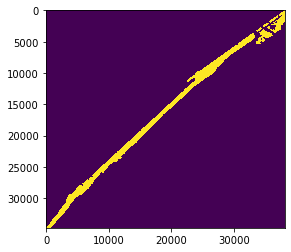

In [8]:
# check rotations using lidar DEM
fn = fdir+fnames[0]
da = xr.open_rasterio(fn)
plt.imshow(np.squeeze(da))


In [9]:
%%time

dslist=[]
for i in range(nf):
    fn = fdir+fnames[i]
    print(i, fn)
    
    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fn)
    
    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    

    if(smooth):
        # smooth with 2D running median
        zs = signal.medfilt2d(z, kernel_size=ksize)
    else:
        zs = z
    
    f = interpolate.RegularGridInterpolator( (y, x), zs, method='linear')   
    
    # Array for interpolated elevations
    zi=np.NaN*np.ones((ny,nx))

    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN
            
    da = xr.DataArray(zi,dims=['Alongshore','Cross-shore'],coords={'Alongshore': ycoords, 'Cross-shore':xcoords })
    # dslist.append(da.chunk()) # this does not work...can't concatenate a method
    da = da.chunk()
    dslist.append(da)

dsa = xr.concat(dslist, dim='map')

0 D:/crs/proj/2019_DorianOBX/WayneWright_flights/post_Matthew_lidar_1m.tif
(34727,) (38113,) (1, 34727, 38113)
(38113,) (34727,) (34727, 38113)
1 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-08-30_1m_DEM_v1_crop.tif
(22393,) (25165,) (1, 22393, 25165)
(25165,) (22393,) (22393, 25165)
2 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-09-12-13_DEM_1m_v1_crop.tif
(22101,) (25420,) (1, 22101, 25420)
(25420,) (22101,) (22101, 25420)
Wall time: 5min 44s


In [10]:
print(np.shape(dsa.values))
dsa.load()

(3, 500, 1800)


<xarray.DataArray (map: 3, Alongshore: 500, Cross-shore: 1800)>
array([[[-4.227842e-02, -5.834684e-02, ..., -2.518436e-01, -2.483739e-01],
        [ 1.047269e-02,  9.393187e-04, ..., -2.341582e-01, -2.331109e-01],
        ...,
        [-8.080528e-01, -7.922446e-01, ...,  6.841041e-01,  7.342958e-01],
        [-7.690433e-01, -7.712837e-01, ...,  6.510642e-01,  7.467786e-01]],

       [[-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        [-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        ...,
        [-1.951562e+00, -3.067698e+00, ...,  8.911451e-01,  9.323287e-01],
        [-1.597911e+00, -1.756603e+00, ...,  8.895140e-01,  9.267743e-01]],

       [[-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        [-3.276700e+04, -3.276700e+04, ..., -3.276700e+04, -3.276700e+04],
        ...,
        [-3.276700e+04, -3.276700e+04, ...,  9.607549e-01,  1.000771e+00],
        [-3.276700e+04, -3.276700e+04, ...,  9.352032e-01,  9.723469

In [11]:
map_stats(dsa)

mean [    1.65046052 -1254.27634549 -1242.7599263 ]
mad [   1.71191964 1258.13449809 1246.00916411]
min [-1.47623482e+00 -3.27670000e+04 -3.27670000e+04]
max [ 6.60924107  8.25695002 11.67303086]
rms [1.96056426e+00 6.38271248e+03 6.34748506e+03]


(array([    1.65046052, -1254.27634549, -1242.7599263 ]),
 array([   1.71191964, 1258.13449809, 1246.00916411]))

In [13]:
### Adjust pre-Dorian map: lower by 17 cm.
dsaa = dsa.copy()
dsaa[1,:,:] = dsaa[1,:,:] - 0.17

dsaa = dsaa.where(dsaa>=0.4)
map_stats(dsaa)

mean [1.87709967 1.99048678 1.86858168]
mad [1.87709967 1.99048678 1.86858168]
min [0.40000408 0.40000307 0.40000465]
max [ 6.60924107  8.08695002 11.67303086]
rms [2.07036986 2.22880261 2.13918556]


(array([1.87709967, 1.99048678, 1.86858168]),
 array([1.87709967, 1.99048678, 1.86858168]))

In [1]:
tcmap=plt.cm.terrain
tcmap.set_bad(color='darkgray')
plt.subplots(figsize=(12,9))
for i in range(nf):
    # small plots of elevation
    plt.subplot(3,1,i+1); plt.pcolormesh(dsaa[i,:,:],cmap=tcmap,vmin=0,vmax=6)
    if(i==2):
        plt.xlabel('Alongshore Distance [m]')
    plt.ylabel('Cross-shore Distance [m]')
    plt.colorbar()

NameError: name 'plt' is not defined

(3, 1800)


Text(0, 0.5, 'Dune Crest Elevation [m]')

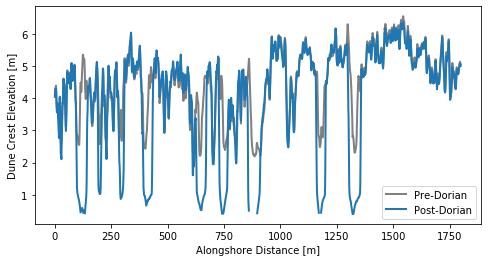

In [89]:
# calculate dhi
dblue = '#1f77b4'
dhi = dsaa[:,0:100,:].max(axis=1,skipna=True)
print(np.shape(dhi))
plt.figure(figsize=(8,4))
plt.plot(dhi[1,:],color='gray',linewidth=2,label='Pre-Dorian')
plt.plot(dhi[2,:],color=dblue,linewidth=2,label='Post-Dorian')
plt.legend()
plt.xlabel('Alongshore Distance [m]')
plt.ylabel('Dune Crest Elevation [m]')

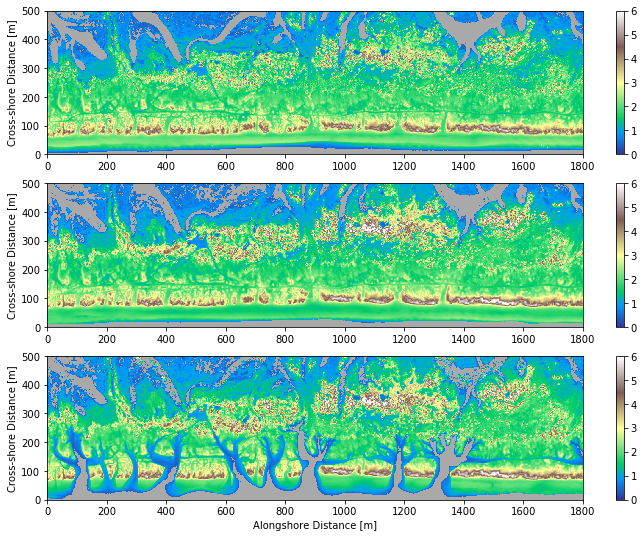

In [87]:
tcmap=plt.cm.terrain
tcmap.set_bad(color='darkgray')
plt.subplots(figsize=(12,9))
for i in range(nf):
    # small plots of elevation
    plt.subplot(3,1,i+1); plt.pcolormesh(dsaa[i,:,:],cmap=tcmap,vmin=0,vmax=6)
    if(i==2):
        plt.xlabel('Alongshore Distance [m]')
    plt.ylabel('Cross-shore Distance [m]')
    plt.colorbar()


In [44]:
map_stats(dsaa)

Shape:  (3, 500, 1800)
mean [1.87709967 1.99048678 1.86858168]
mad [1.87709967 1.99048678 1.86858168]
min [0.40000408 0.40000307 0.40000465]
max [ 6.60924107  8.08695002 11.67303086]
rms [2.07036986 2.22880261 2.13918556]
nans [96813, 103645, 124146]
size [900000, 900000, 900000]


(array([1.87709967, 1.99048678, 1.86858168]),
 array([1.87709967, 1.99048678, 1.86858168]))

xs_len =  250.0
(3, 1800) (2, 1800)


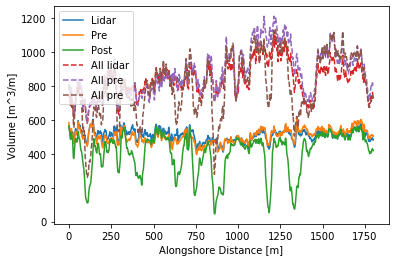

In [48]:
# calculate volumes
xs_start = 0
xs_end = 250
xs_len = (xs_end-xs_start)*dxy
print('xs_len = ',xs_len)
v = np.nansum(dsaa[:,xs_start:xs_end,:],axis=1)
vall = np.nansum(dsaa[:,:,:],axis=1)
vdiff = np.diff(v,axis=0)
vdiffall = np.diff(vall,axis=0)

print(np.shape(v),np.shape(vdiff))
plt.plot(v[0,:],label='Lidar')
plt.plot(v[1,:],label='Pre')
plt.plot(v[2,:],label='Post')

plt.plot(vall[0,:],'--',label='All lidar')
plt.plot(vall[1,:],'--',label='All pre')
plt.plot(vall[2,:],'--',label='All pre')

plt.xlabel('Alongshore Distance [m]')
plt.ylabel('Volume [m^3/m]')
plt.legend()

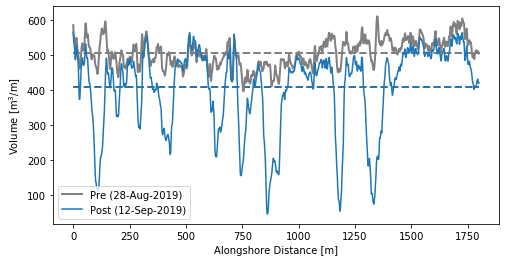

In [90]:
# Nicer plot for presentation - SfM only
m = np.mean(v,1)
plt.figure(figsize=(8,4))
plt.plot([0, 1800],[m[1],m[1]],'--',color='gray',linewidth=2)
plt.plot([0, 1800],[m[2],m[2]],'--',color='#1f77b4',linewidth=2)
plt.plot(v[1,:],label='Pre (28-Aug-2019)',color='gray',linewidth=2)
plt.plot(v[2,:],label='Post (12-Sep-2019)')
plt.xlabel(r'Alongshore Distance [m]')
plt.ylabel(r'Volume [m$^3$/m]')
plt.legend()
#plt.savefig('fig1.png', dpi = 300)


In [58]:
print("Average volume in first 250 m: ",np.mean(v,1)," [m3/m]")
print("Average elevation in first 250 m: ",np.mean(v,1)/xs_len,"[m]")
m = np.nanmean(np.nanmean(dsaa[:,0:250,:],1),1)
mall = np.nanmean(np.nanmean(dsaa,1),1)
pc = 100*np.mean(vdiff,1)/np.mean(v[1:],1)
pcall = 100*np.mean(vdiffall,1)/np.mean(vall[1:],1)

print("Preferred estimate of average elevation in first 250 m:",m)
print("Mean volume change in first 250 m:",np.mean(vdiff,1),"[m3/m]")
print("Pct volume change in first 250 m:",pc,"[m3/m]")

print(" ")
print("Average volume region: ",np.mean(vall,1)," [m3/m]")
print("Average elevation region: ",np.mean(vall,1)/500,"[m]")
print("Preferred estimate of average elevation region",mall)
print("Mean volume change region:",np.mean(vdiffall,1),"[m3/m]")
print("Pct volume change in first 250 m:",pcall,"[m3/m]")

Average volume in first 250 m:  [509.93027382 504.95735042 406.93078232]  [m3/m]
Average elevation in first 250 m:  [2.0397211  2.0198294  1.62772313] [m]
Check average elevation first 250 m: [2.1879136  2.19387397 1.92287737]
Mean volume change in first 250 m: [ -4.97292339 -98.02656811] [m3/m]
Pct volume change in first 250 m: [ -0.98482048 -24.08924868] [m3/m]
 
Average volume region:  [837.59003053 880.63005321 805.41476295]  [m3/m]
Average elevation region:  [1.67518006 1.76126011 1.61082953] [m]
Check average elevation region [1.87511169 1.98642363 1.85161459]
Mean volume change region: [ 43.04002268 -75.21529025] [m3/m]
Pct volume change in first 250 m: [ 4.88741243 -9.33870271] [m3/m]


### Note on the difference between difference calculations
The distribution of NaNs in each map is different. NaNs occur in the back-barrier creeks and on the foreshore, where elevations are below MHW. As a result, the difference of the volume sums is not the same as the sum of the volume diffs.

I think the former is more representative because it accounts for the loss in channels near the beach, and because it involves fewer NaNs, because NaNs from either map propagate to the difference map, but only NaNs from individual maps appear in the volume calcs. So, use the numbers above, rather than those below.

Stats for dsaa:
Shape:  (3, 500, 1800)
mean [1.87709967 1.99048678 1.86858168]
mad [1.87709967 1.99048678 1.86858168]
min [0.40000408 0.40000307 0.40000465]
max [ 6.60924107  8.08695002 11.67303086]
rms [2.07036986 2.22880261 2.13918556]
nans [96813, 103645, 124146]
size [900000, 900000, 900000]
Stats for diffmap:
Shape:  (2, 500, 1800)
mean [ 0.10288645 -0.09493917]
mad [0.28042212 0.29367512]
min [-4.26411898 -5.02179541]
max [3.75857724 6.7046924 ]
rms [0.4317806  0.50394266]
nans [113092, 150552]
size [900000, 900000]
(2, 1800)


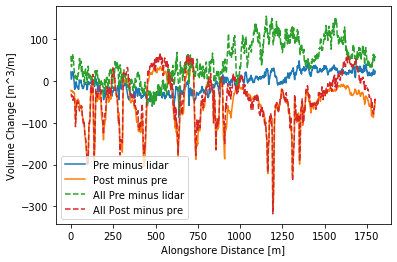

In [46]:
# calculate difference maps
xs_start = 0
xs_end = 250
xs_len = (xs_end-xs_start)*dxy

print("Stats for dsaa:")
map_stats(dsaa)

diffmap = np.diff(dsaa,axis=0)
print("Stats for diffmap:")
map_stats(diffmap)
dv = np.nansum(diffmap[:,0:250,:],axis=1)
dvall = np.nansum(diffmap[:,:,:],axis=1)
print(np.shape(dv))
plt.plot(dv[0,:],label='Pre minus lidar')
plt.plot(dv[1,:],label='Post minus pre')
plt.plot(dvall[0,:],'--',label='All Pre minus lidar')
plt.plot(dvall[1,:],'--',label='All Post minus pre')
plt.xlabel('Alongshore Distance [m]')
plt.ylabel('Volume Change [m^3/m]')
plt.legend()

In [17]:
print("Average volume changes: ",np.mean(dv,1)," [m3/m]")
print("Average elevation changes: ",np.mean(dv,1)/xs_len,"[m]")

Average volume changes:  [ -3.20492844 -53.14409188]  [m3/m]
Average elevation changes:  [-0.01281971 -0.21257637] [m]


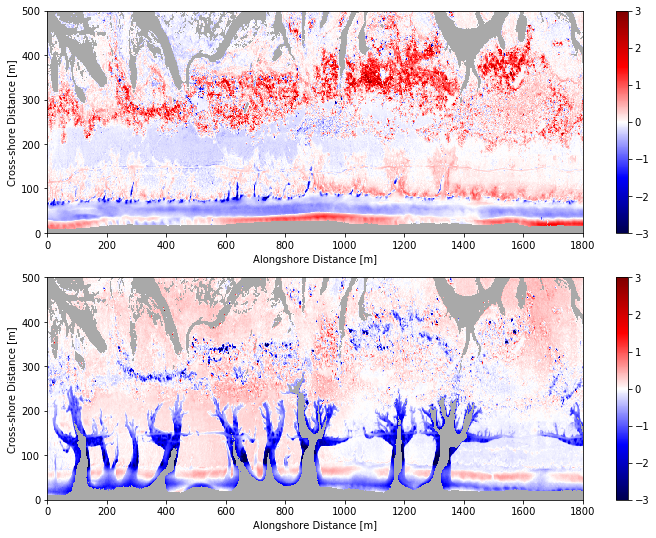

In [85]:
# plot diff maps
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
    
plt.subplots(figsize=(12,9))
for i in range(2):
    # small plots of elevation
    plt.subplot(2,1,i+1); plt.pcolormesh(diffmap[i,:,:],cmap=dcmap,vmin=-3,vmax=3.)
    plt.ylabel('Cross-shore Distance [m]')
    plt.xlabel('Alongshore Distance [m]')
    plt.colorbar()